In [4]:
import numpy as np
from skimage.io import imread, imsave
from skimage.data import cells3d
from skimage.filters import gaussian
from scipy.ndimage import convolve
from napari_simpleitk_image_processing import richardson_lucy_deconvolution
import matplotlib.pyplot as plt
from skimage import img_as_float
import imageio.v2 as iio
import tifffile as tiff

In [4]:
image = img_as_float(iio.imread("cells3d.tif"))[:,1,119:190,79:150]
# imshow(image)

(-0.5, 70.5, 70.5, -0.5)

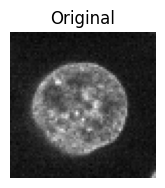

In [5]:
plt.subplot(1, 3, 1)
plt.imshow(image[30], cmap='gray')
plt.title('Original')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

(-0.5, 70.5, 70.5, -0.5)

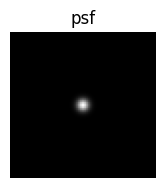

In [6]:
perfect_psf = np.zeros( (61,71,71) )
perfect_psf[31,35,35] = 1
psf = gaussian(perfect_psf, sigma=2)

plt.subplot(1, 3, 1)
plt.imshow(psf[31], cmap='gray')
plt.title('psf')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

(-0.5, 70.5, 70.5, -0.5)

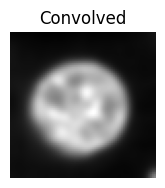

In [7]:
convolved = convolve(image, psf)

plt.subplot(1, 3, 1)
plt.imshow(convolved[30], cmap='gray')
plt.title('Convolved')
plt.axis('off') 

In [8]:
convolved.shape

(60, 71, 71)

(-0.5, 70.5, 70.5, -0.5)

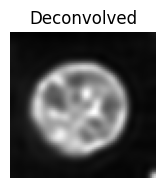

In [7]:
number_of_iterations = 30
deconvolved = richardson_lucy_deconvolution(convolved, psf, number_of_iterations)

plt.subplot(1, 3, 1)
plt.imshow(deconvolved[30], cmap='gray')
plt.title('Deconvolved')
plt.axis('off') 

In [8]:
%timeit -n 1 -r 10  richardson_lucy_deconvolution(convolved, psf, number_of_iterations)

9.96 s ± 18.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


---
## Cube of Spherical Beads

In [34]:
# Cargamos la imagen
cubeImg = img_as_float(iio.imread("ref.tif"))

# Cargamos la PSF

cubePSF = img_as_float(iio.imread("PSF.tif"))[48:80,48:80,48:80]

print(cubeImg.shape)
print(cubePSF.shape)

(128, 128, 128)
(32, 32, 32)


(-0.5, 127.5, 127.5, -0.5)

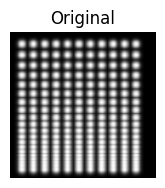

In [35]:
plt.subplot(1, 3, 1)
plt.imshow(cubeImg[30], cmap='gray')
plt.title('Original')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

(-0.5, 127.5, 127.5, -0.5)

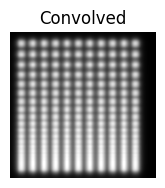

In [36]:
cubeConvolved = convolve(cubeImg, cubePSF)

tiff.imwrite('cubeConvolved.tif', cubeConvolved.astype('float32'))


plt.subplot(1, 3, 1)
plt.imshow(cubeConvolved[30], cmap='gray')
plt.title('Convolved')
plt.axis('off') 

(-0.5, 127.5, 127.5, -0.5)

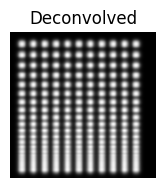

In [7]:
number_of_iterations = 30
deconvolved = richardson_lucy_deconvolution(cubeConvolved, cubePSF, number_of_iterations)

plt.subplot(1, 3, 1)
plt.imshow(deconvolved[30], cmap='gray')
plt.title('Deconvolved')
plt.axis('off') 

In [8]:
%timeit -n 1 -r 10  richardson_lucy_deconvolution(cubeConvolved, cubePSF, number_of_iterations)

23.3 s ± 170 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


---
## C. elegans embryo

In [5]:
import os

def load_image_stack(folder_path):
    # Listar todos los archivos en la carpeta y ordenar
    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif') or f.endswith('.png') or f.endswith('.jpg')])

    # Leer la primera imagen para obtener las dimensiones
    first_image = iio.imread(os.path.join(folder_path, files[0]))
    height, width = first_image.shape

    # Crear una matriz 3D vacía para almacenar las imágenes
    image_stack = np.zeros((len(files), height, width), dtype=first_image.dtype)

    # Cargar cada imagen en la matriz 3D
    for i, file in enumerate(files):
        image_stack[i, :, :] = iio.imread(os.path.join(folder_path, file))

    return image_stack


## Canal 1

In [7]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath = '/Users/yi/TFGNotebook/CElegans-CY3'
psfPath = '/Users/yi/TFGNotebook/PSF-CElegans-CY3'

# Cargar las imágenes en una matriz 3D
image_stack = load_image_stack(imagePath)[:,0:356,0:336]
psf_stack = load_image_stack(psfPath)[:, 178:534, 168:504] #mitad +152

# Verificar las dimensiones de las matrices 3D
print(image_stack.shape)
print(psf_stack.shape)

(104, 356, 336)
(104, 356, 336)


(-0.5, 335.5, 355.5, -0.5)

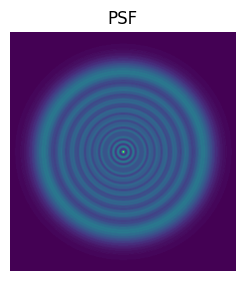

In [8]:
plt.subplot(1, 2, 2)
plt.imshow(psf_stack[1])
plt.title('PSF')
plt.axis('off')

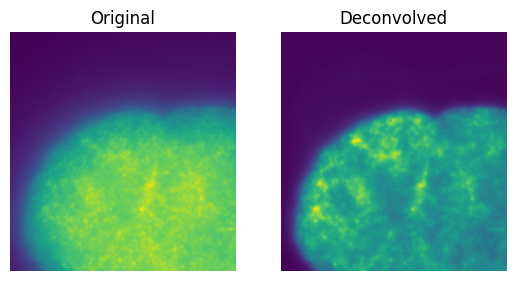

In [9]:
#deconvolved_stack = np.zeros_like(image_stack)
num_iterations = 50  # Número de iteraciones para el algoritmo de Richardson-Lucy

deconvolved_stack = richardson_lucy_deconvolution(image_stack, psf_stack, num_iterations)

# Visualizar un plano específico de la imagen deconvolucionada
plt.subplot(1, 2, 1)
plt.imshow(image_stack[52])
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(deconvolved_stack[52])
plt.title('Deconvolved')
plt.axis('off')

plt.show()

In [10]:
%timeit -n 1 -r 6  richardson_lucy_deconvolution(image_stack, psf_stack, 1)

10.4 s ± 448 ms per loop (mean ± std. dev. of 6 runs, 1 loop each)


## Canal 2

In [11]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath2 = '/Users/yi/TFGNotebook/CElegans-DAPI'
psfPath2 = '/Users/yi/TFGNotebook/PSF-CElegans-DAPI'

# Cargar las imágenes en una matriz 3D
image_stack2 = load_image_stack(imagePath2)[:,0:356,0:336]
psf_stack2 = load_image_stack(psfPath2)[:, 178:534, 168:504] #mitad +152

# Verificar las dimensiones de las matrices 3D
print(image_stack2.shape)
print(psf_stack2.shape)

(104, 356, 336)
(104, 356, 336)


(-0.5, 335.5, 355.5, -0.5)

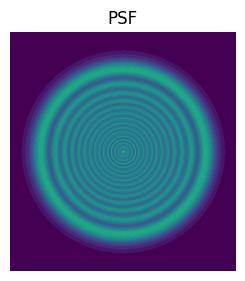

In [12]:
plt.subplot(1, 2, 2)
plt.imshow(psf_stack2[1])
plt.title('PSF')
plt.axis('off')

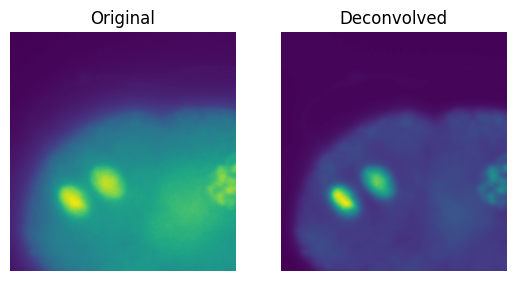

In [13]:
#deconvolved_stack2 = np.zeros_like(image_stack2)
num_iterations = 50  # Número de iteraciones para el algoritmo de Richardson-Lucy

deconvolved_stack2 = richardson_lucy_deconvolution(image_stack2, psf_stack2, num_iterations)

# Visualizar un plano específico de la imagen deconvolucionada
plt.subplot(1, 2, 1)
plt.imshow(image_stack2[52])
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(deconvolved_stack2[52])
plt.title('Deconvolved')
plt.axis('off')

plt.show()

## Canal 3

In [14]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath3 = '/Users/yi/TFGNotebook/CElegans-FITC'
psfPath3 = '/Users/yi/TFGNotebook/PSF-CElegans-FITC'

# Cargar las imágenes en una matriz 3D
image_stack3 = load_image_stack(imagePath3)[:,0:356,0:336]
psf_stack3 = load_image_stack(psfPath3)[:, 178:534, 168:504] #mitad +152

# Verificar las dimensiones de las matrices 3D
print(image_stack3.shape)
print(psf_stack3.shape)

(104, 356, 336)
(104, 356, 336)


(-0.5, 335.5, 355.5, -0.5)

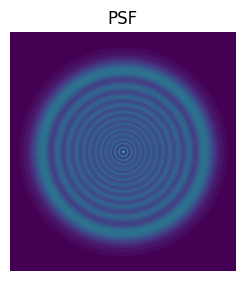

In [15]:
plt.subplot(1, 2, 2)
plt.imshow(psf_stack3[1])
plt.title('PSF')
plt.axis('off')

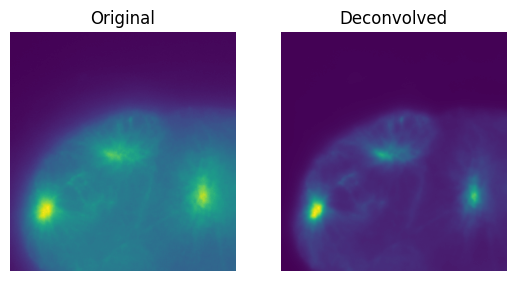

In [16]:
#deconvolved_stack3 = np.zeros_like(image_stack3)

num_iterations = 50  # Número de iteraciones para el algoritmo de Richardson-Lucy

deconvolved_stack3 = richardson_lucy_deconvolution(image_stack3, psf_stack3, num_iterations)

# Visualizar un plano específico de la imagen deconvolucionada
plt.subplot(1, 2, 1)
plt.imshow(image_stack3[52])
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(deconvolved_stack3[52])
plt.title('Deconvolved')
plt.axis('off')

plt.show()

#### Combinación de canales

(-0.5, 335.5, 355.5, -0.5)

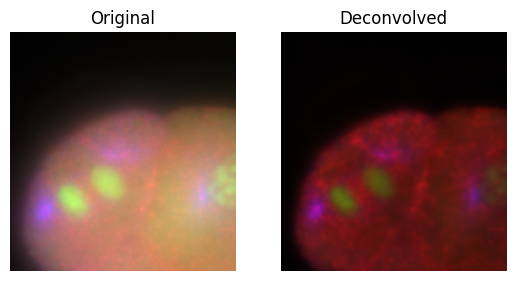

In [17]:
# Normalizar los canales (opcional, pero recomendado)
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    if min_val == max_val:
        return np.zeros_like(image)  # O np.ones_like(image), dependiendo de tu preferencia
    return (image - min_val) / (max_val - min_val)
deconvolved_stack_R = normalize(deconvolved_stack)
deconvolved_stack_G = normalize(deconvolved_stack2)
deconvolved_stack_B = normalize(deconvolved_stack3)

# Combinar los tres canales en una sola matriz 4D (profundidad, altura, ancho, canales)
deconvolved_stack_color = np.stack((deconvolved_stack_R, deconvolved_stack_G, deconvolved_stack_B), axis=-1)

# Visualizar un plano específico de la imagen deconvolucionada en color
plt.subplot(1, 2, 1)
plt.imshow(np.stack((normalize(image_stack[52]), normalize(image_stack2[52]), normalize(image_stack3[52])), axis=-1))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(deconvolved_stack_color[52])
plt.title('Deconvolved')
plt.axis('off')
